In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_0irEZ2H.csv')
test = pd.read_csv('test_nfaJ3J5.csv')

print(train.shape, test.shape)

(150150, 9) (13860, 8)


In [3]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB
None


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


As seen from data info, we have 9 columns where 'record_ID' is an indexing column, 'store_id' and 'sku_id' are identifiers. The target 
variable is 'units_sold'. All the columns are numercal except for week which is read as object which we will convert to datetime format . Also, we don't need to preprocess data as there are no nulls except for 1 row for total price

In [8]:
### Adding a concatenated column for store X SKU as we need to predict units at this particular level
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))

### Converting 'week' to datetime
train['week'] = pd.to_datetime(train['week'])

### Null replacement for 'total_price'

In [11]:
print(train[train.total_price.isnull()])

        record_ID       week  store_id  sku_id  total_price  base_price  \
136949     193915 2013-04-23      9436  245338          NaN    469.5375   

        is_featured_sku  is_display_sku  units_sold    store_sku  
136949                0               0           1  9436_245338  


In [12]:
### Looking at data for specific store-sku in nearby time period. We will replace with the last price value for null total_price 
train[train.sku_id == 245338][train.store_id == 9436][train.week.dt.year == 2013][train.week.dt.month <= 5].sort_values(by = 'week')

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku
118469,167768,2013-01-01,9436,245338,469.5375,469.5375,0,0,7,9436_245338
120779,171031,2013-01-15,9436,245338,469.5375,469.5375,0,0,11,9436_245338
121934,172673,2013-01-22,9436,245338,469.5375,469.5375,0,0,3,9436_245338
123089,174299,2013-01-29,9436,245338,469.5375,469.5375,0,0,4,9436_245338
133484,189007,2013-02-04,9436,245338,352.6875,469.5375,1,1,14,9436_245338
148499,210293,2013-02-07,9436,245338,375.4875,483.7875,0,0,11,9436_245338
126554,179175,2013-02-19,9436,245338,469.5375,469.5375,0,0,7,9436_245338
127709,180808,2013-02-26,9436,245338,469.5375,469.5375,0,0,9,9436_245338
131174,185728,2013-03-19,9436,245338,339.8625,469.5375,1,1,30,9436_245338
132329,187366,2013-03-26,9436,245338,339.8625,469.5375,1,1,16,9436_245338


In [14]:
### Sorting data and replacing null using last value (backfill method)
train = train.sort_values(by = ['store_id','sku_id','week'])
train['total_price'] = train['total_price'].fillna(method='bfill')
train[train.sku_id == 245338][train.store_id == 9436][train.week.dt.year == 2013][train.week.dt.month == 4]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku
143879,203737,2013-04-06,9436,245338,375.4875,483.7875,0,0,4,9436_245338
135794,192283,2013-04-16,9436,245338,469.5375,469.5375,0,0,4,9436_245338
136949,193915,2013-04-23,9436,245338,480.2250,469.5375,0,0,1,9436_245338
138104,195549,2013-04-30,9436,245338,480.2250,480.2250,0,0,5,9436_245338


### Analysing Data (EDA)

In [18]:
train.describe()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,2012-04-18 17:54:27.692307968,9199.422511,254761.132468,206.628573,219.425927,0.095611,0.133200,51.674206
min,1.000000,2011-01-08 00:00:00,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,2011-08-22 00:00:00,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,2012-04-10 12:00:00,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,2012-11-20 00:00:00,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,2013-12-03 00:00:00,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000
std,61386.037861,NaN,615.591445,85547.306447,103.310585,110.961712,0.294058,0.339792,60.207904


Text(0, 0.5, 'units_sold')

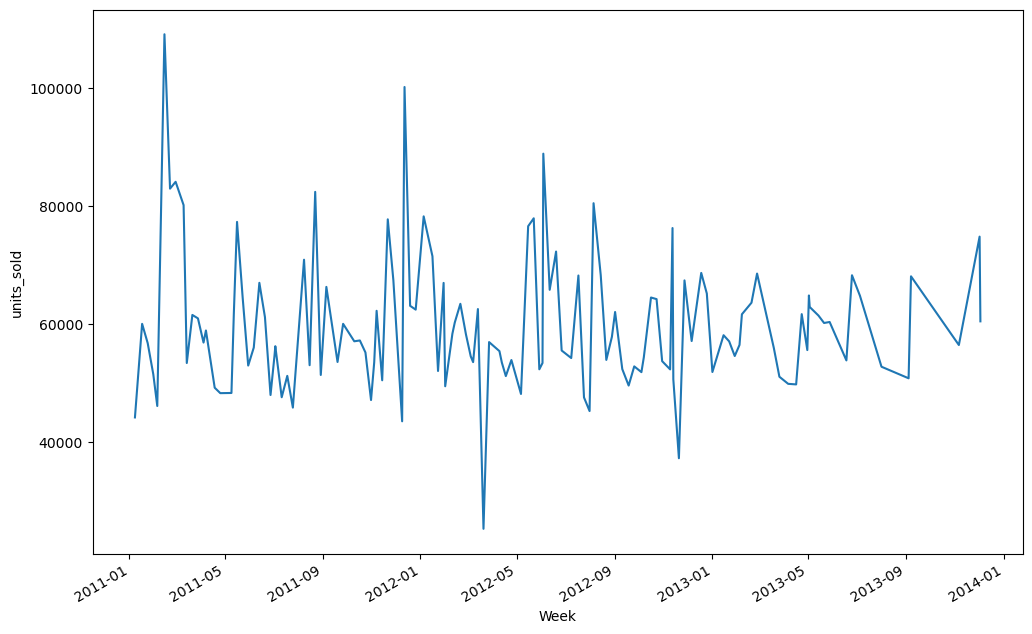

In [19]:
train.groupby('week').sum()['units_sold'].plot(figsize=(12,8))
plt.xlabel('Week')
plt.ylabel('units_sold')

In [21]:
### Adding datetime features
train['Month'] = pd.to_datetime(train['week']).dt.month.astype(int)
train['week_year'] = pd.to_datetime(train['week']).dt.isocalendar().week

Text(0, 0.5, 'units_sold')

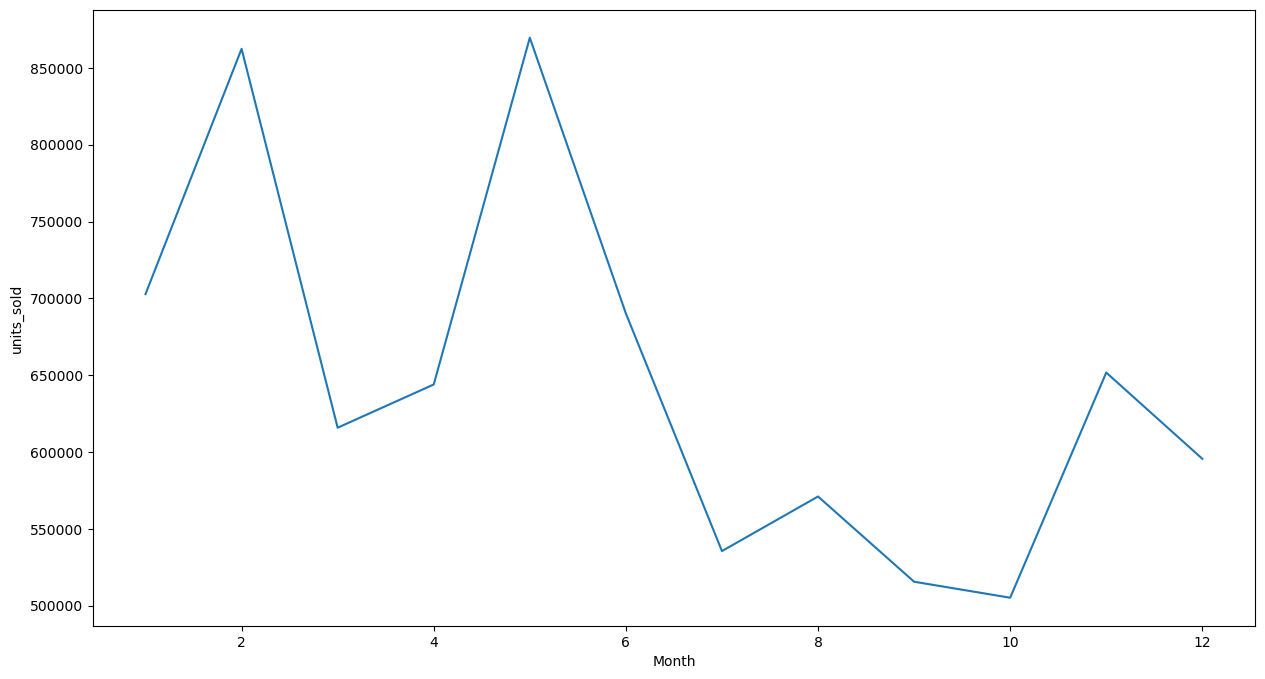

In [22]:
train.groupby('Month')['units_sold'].sum().plot(figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('units_sold')

In [23]:
# Making price based new features

train['diff'] = train['base_price'] - train['total_price']
train['relative_diff_base'] = train['diff']/train['base_price']
train['relative_diff_total'] = train['diff']/train['total_price']
train.head(5)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_sku,Month,week_year,diff,relative_diff_base,relative_diff_total
32415,45883,2011-01-08,8023,216233,133.9500,133.9500,0,0,119,8023_216233,1,1,0.0,0.0,0.0
75,99,2011-01-17,8023,216233,134.6625,134.6625,0,0,114,8023_216233,1,3,0.0,0.0,0.0
1230,1739,2011-01-24,8023,216233,133.9500,133.9500,0,0,87,8023_216233,1,4,0.0,0.0,0.0
2385,3375,2011-01-31,8023,216233,133.9500,133.9500,0,0,135,8023_216233,1,5,0.0,0.0,0.0
17400,24612,2011-02-05,8023,216233,133.9500,133.9500,0,0,98,8023_216233,2,5,0.0,0.0,0.0


In [24]:
# Studying correlation between features and the target. This will help us in regression later.
cols = ['base_price', 'total_price', 'diff', 'relative_diff_base', 'relative_diff_total','units_sold']
train[cols].corr().loc['units_sold']

base_price            -0.140032
total_price           -0.235634
diff                   0.278284
relative_diff_base     0.364842
relative_diff_total    0.365690
units_sold             1.000000
Name: units_sold, dtype: float64

In [32]:
### categorical - continuous variable correlation using Point Biserial Test which is a special case of the Pearson correlation
train[['is_featured_sku', 'is_display_sku']].corrwith(\
    train['units_sold'].astype('float'), method=stats.pointbiserialr)

,is_featured_sku,is_display_sku
0,0.337751,0.362662
1,0.000000,0.000000


<Axes: >

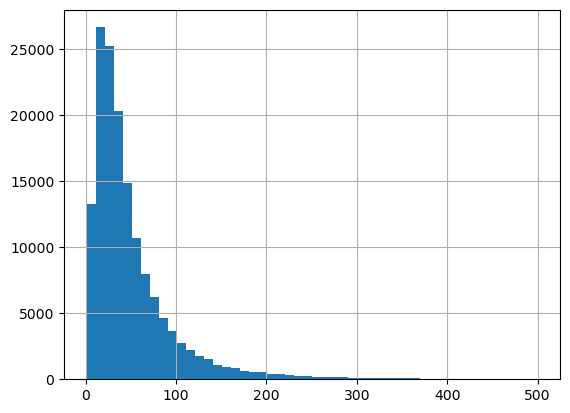

In [34]:
train[train.units_sold<= 500].units_sold.hist(bins=50)

units_sold distribution is clearly very skewed and resembles exponential decay plot. Hence, we will transform data using 
log transformation for normalization to make better predictions.

<Axes: >

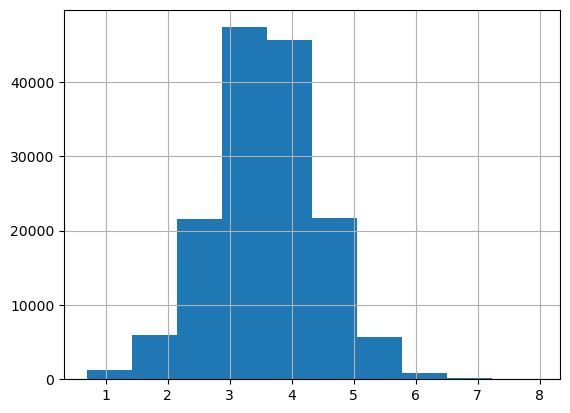

In [37]:
np.log1p(train['units_sold']).hist()

In [44]:
X_model = train.drop(columns = ['record_ID', 'store_id', 'sku_id', 'week', 'units_sold'])
y_model = np.log1p(train['units_sold'])

X_train, X_test= np.split(X_model, [int(.80 *len(X_model))])
y_train, y_test= np.split(y_model, [int(.80 *len(y_model))])

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor()
rf_base.fit(X_train,y_train)


rf_tuned = RandomForestRegressor(bootstrap=True, criterion='squared_error', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, 
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=True, random_state=None,
                      verbose=0, warm_start=False)
rf_tuned.fit(X_train,y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=10,
                      n_estimators=600, oob_score=True)

In [55]:
def rmlse(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true)-np.log1p(y_pred), 2)))

In [60]:
prediction_rfb_valid=rf_base.predict(X_test)
prediction_rft_valid=rf_tuned.predict(X_test)

rf_base_msle=100*rmlse(y_test,prediction_rfb_valid)
rf_tuned_msle=100*rmlse(y_test,prediction_rft_valid)

print("RF Base: {}; RF Tuned: {}".format(rf_base_msle,rf_tuned_msle))

RF Base: 18.76514885795083; RF Tuned: 16.17615218506924


### Preparing Testing data for prediction (same processing as train)

In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_ID        13860 non-null  int64  
 1   week             13860 non-null  object 
 2   store_id         13860 non-null  int64  
 3   sku_id           13860 non-null  int64  
 4   total_price      13860 non-null  float64
 5   base_price       13860 non-null  float64
 6   is_featured_sku  13860 non-null  int64  
 7   is_display_sku   13860 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 866.4+ KB


In [67]:
### Adding a concatenated column for store X SKU as we need to predict units at this particular level
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))

### Converting 'week' to datetime
test['week'] = pd.to_datetime(test['week'])

### Adding datetime features
test['Month'] = pd.to_datetime(test['week']).dt.month.astype(int)
test['week_year'] = pd.to_datetime(test['week']).dt.isocalendar().week

# Making price based new features
test['diff'] = test['base_price'] - test['total_price']
test['relative_diff_base'] = test['diff']/test['base_price']
test['relative_diff_total'] = test['diff']/test['total_price']

In [73]:
test_model = test.drop(columns = ['record_ID', 'store_id', 'sku_id', 'week'])

In [75]:
predictions_rfb_tuned_test =rf_tuned.predict(test_model)
final_predictions=np.round(np.expm1(predictions_rfb_tuned_test))

In [77]:
test['out'] = final_predictions
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,store_sku,Month,week_year,diff,relative_diff_base,relative_diff_total,out
0,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0,8091_216418,7,29,0.0,0.0,0.0,32.0
1,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0,8091_216419,7,29,0.0,0.0,0.0,27.0
2,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0,8091_216425,7,29,0.0,0.0,0.0,30.0
3,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0,8091_216233,7,29,0.0,0.0,0.0,30.0
4,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0,8091_217390,7,29,0.0,0.0,0.0,39.0
